In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ✅ Load YOLOv8 Models
traffic_light_model = YOLO("models/traffic_light_model.pt")  # Detects red/green lights
zebra_crossing_model = YOLO("models/zebra_crossing_yolov8.pt")  # Detects zebra crossings

# ✅ Speed Variable (for now, assume speed = 30)
SPEED = 30  # Change this to test different cases

# ✅ Function to detect traffic light and check if it's RED
def detect_red_light(image):
    results = traffic_light_model(image)
    red_detected = False

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box
            conf = box.conf[0].item()  # Confidence score
            cls = int(box.cls[0].item())  # Class index

            if cls == 1 and conf >= 0.25:  # Class 1 is RED Light (threshold 50%)
                red_detected = True
                print(f"🚦 Red Traffic Light Detected - Confidence: {conf:.2f}")
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Red box
                cv2.putText(image, f"Red Light: {conf:.2f}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    
    return red_detected

# ✅ Function to detect zebra crossing
def detect_zebra_crossing(image):
    results = zebra_crossing_model(image)
    zebra_detected = False

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box
            conf = box.conf[0].item()  # Confidence score

            if conf >= 0.25:  # Threshold 50%
                zebra_detected = True
                print(f"🦓 Zebra Crossing Detected - Confidence: {conf:.2f}")
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 3)  # Green box
                cv2.putText(image, f"Zebra Crossing: {conf:.2f}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    return zebra_detected

# ✅ Run the violation detection logic on a manual image
def check_violation(image_path):
    print(f"🔍 Testing on image: {image_path}")

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Step 1: Check if red light is present
    is_red_light = detect_red_light(image)

    if not is_red_light:
        print("✅ No Violation (No Red Light)")
        title = "✅ No Violation (No Red Light)"
        show_image(image, title)
        return

    # Step 2: Check if zebra crossing is present
    is_zebra_crossing = detect_zebra_crossing(image)

    if is_zebra_crossing:
        print("✅ No Violation (Zebra Crossing Present)")
        title = "✅ No Violation (Zebra Crossing Present)"
        show_image(image, title)
        return

    # Step 3: Check Speed
    if SPEED > 0:
        print("❌ Violation Detected (Red Light + No Zebra Crossing + Moving Vehicle)")
        title = "❌ Violation Detected!"
    else:
        print("✅ No Violation (Stopped at Red Light)")
        title = "✅ No Violation (Stopped at Red Light)"

    # Show final image
    show_image(image, title)

# ✅ Function to display image

def show_image(image, title):
    %matplotlib inline
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(title, fontsize=14, fontweight="bold", color="blue")
    plt.show()



🔍 Testing on image: C:\Users\atulg\OneDrive\Desktop\images (1).jpg

0: 640x640 1 red, 107.9ms
Speed: 6.2ms preprocess, 107.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
🚦 Red Traffic Light Detected - Confidence: 0.47

0: 640x640 1 Zebra-Crossing, 111.5ms
Speed: 5.1ms preprocess, 111.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
🦓 Zebra Crossing Detected - Confidence: 0.35
✅ No Violation (Zebra Crossing Present)


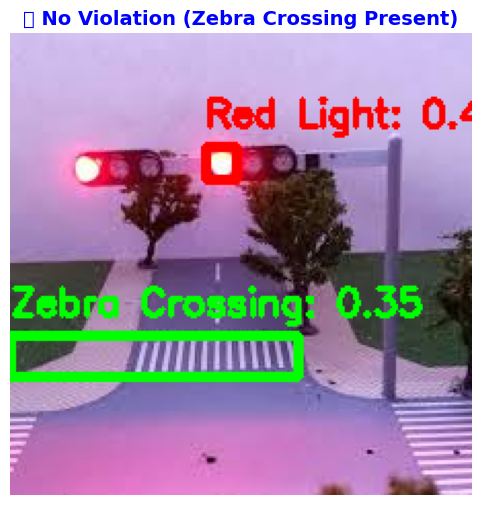

In [13]:
# ✅ Test with a manually selected image
image_path = r"C:\Users\atulg\OneDrive\Desktop\images (1).jpg" # Change this path to your test image
check_violation(image_path)


🔍 Testing on image: C:\Users\atulg\OneDrive\Desktop\COLOURBOX60275950.webp

0: 640x640 (no detections), 156.5ms
Speed: 12.2ms preprocess, 156.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
✅ No Violation (No Red Light)


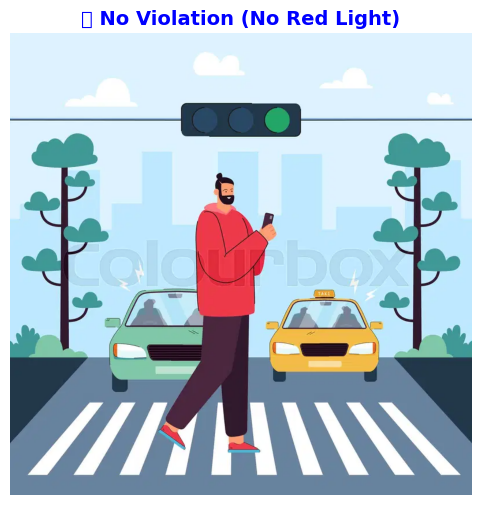

In [14]:
# ✅ Test with a manually selected image
image_path = r"C:\Users\atulg\OneDrive\Desktop\COLOURBOX60275950.webp" # Change this path to your test image
check_violation(image_path)


FLASK FOR VIOLATION DETECTION FINAL


In [ ]:
from flask import Flask, request, jsonify
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ✅ Initialize Flask app
app = Flask(__name__)

# ✅ Folder to save uploaded images
UPLOAD_FOLDER = "uploads"
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
app.config["UPLOAD_FOLDER"] = UPLOAD_FOLDER

# ✅ Load YOLOv8 Models
traffic_light_model = YOLO("models/traffic_light_model.pt")  # Detects red/green lights
zebra_crossing_model = YOLO("models/zebra_crossing_yolov8.pt")  # Detects zebra crossings

# ✅ Speed Variable (for now, assume speed = 30)
SPEED = 30  # Replace with actual ESP32 speed input in future

# ✅ Store the latest motor control command (default: Stop)
current_command = "S"

# ✅ Function to detect traffic light and check if it's RED
def detect_red_light(image):
    results = traffic_light_model(image)
    red_detected = False

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box
            conf = box.conf[0].item()  # Confidence score
            cls = int(box.cls[0].item())  # Class index

            if cls == 1 and conf >= 0.25:  # Class 1 is RED Light (threshold 25%)
                red_detected = True
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Red box
                cv2.putText(image, f"Red Light: {conf:.2f}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    return red_detected, image  # ✅ Return modified image

# ✅ Function to detect zebra crossing
def detect_zebra_crossing(image):
    results = zebra_crossing_model(image)
    zebra_detected = False

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box
            conf = box.conf[0].item()  # Confidence score

            if conf >= 0.25:  # Threshold 25%
                zebra_detected = True
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 3)  # Green box
                cv2.putText(image, f"Zebra: {conf:.2f}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    return zebra_detected, image  # ✅ Return modified image

# ✅ Function to process image and check for violations
def check_violation(image_path):
    print(f"🔍 Processing image: {image_path}")

    # ✅ Check if file exists
    if not os.path.exists(image_path):
        print("❌ Error: Image file not found!")
        return "❌ Error: Image file not found!"

    # ✅ Load image with OpenCV
    image = cv2.imread(image_path)

    # ✅ Ensure OpenCV successfully loaded the image
    if image is None:
        print("❌ Error: Failed to load image!")
        return "❌ Error: Failed to load image!"

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Step 1: Check if red light is present
    is_red_light, image = detect_red_light(image)

    if not is_red_light:
        result = "✅ No Violation (No Red Light)"
    else:
        # Step 2: Check if zebra crossing is present
        is_zebra_crossing, image = detect_zebra_crossing(image)

        if is_zebra_crossing:
            result = "✅ No Violation (Zebra Crossing Present)"
        else:
            # Step 3: Check Speed
            if SPEED > 0:
                result = "❌ Violation Detected (Red Light + No Zebra Crossing + Moving Vehicle)"
            else:
                result = "✅ No Violation (Stopped at Red Light)"

    print(result)

    # ✅ Save original & processed images
    original_path = os.path.join(app.config["UPLOAD_FOLDER"], "original_image.jpg")
    processed_path = os.path.join(app.config["UPLOAD_FOLDER"], "processed_image.jpg")
    cv2.imwrite(original_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    cv2.imwrite(processed_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    return result

# ✅ Flask API: Upload Image & Get Violation Detection Result (Violation Status NOT sent to ESP32)
@app.route('/upload', methods=['POST'])
def upload_file():
    try:
        if request.data == b'':
            return jsonify({"error": "No image data received"}), 400
        
        file_path = os.path.join(app.config["UPLOAD_FOLDER"], "captured_image.jpg")

        with open(file_path, "wb") as f:
            f.write(request.data)  # Save raw image data
        print(f"✅ Image received and saved as {file_path}")

        # ✅ Run violation detection (only for logging, NOT sent to ESP32)
        check_violation(file_path)

        return jsonify({
            "message": "Image received & processed"
        }), 200

    except Exception as e:
        return jsonify({"error": str(e)}), 500

# ✅ API to set motor control command
@app.route('/set_command', methods=['POST'])
def set_command():
    global current_command
    data = request.get_json()

    if not data or "command" not in data:
        return jsonify({"error": "Missing command"}), 400

    command = data["command"].upper()

    if command not in ["F", "B", "S", "R", "L"]:
        return jsonify({"error": "Invalid command"}), 400

    current_command = command  # ✅ Store the latest command
    print(f"✅ Motor Command updated: {current_command}")

    return jsonify({"message": f"Motor Command set to {current_command}"}), 200

# ✅ API for ESP32 to fetch the latest motor control command
@app.route('/get_command', methods=['GET'])
def get_command():
    return jsonify({"command": current_command}), 200

# ✅ Home route
@app.route('/')
def home():
    return "🚀 Flask server is running! Use /set_command and /get_command to control ESP32."

# ✅ Run Flask server
if __name__ == '__main__':
    print("🚀 Flask server has started!")
    print("🔹 Access it at: http://0.0.0.0:5000")
    app.run(host='0.0.0.0', port=5000)  # Allows access from ESP32


🚀 Flask server has started!
🔹 Access it at: http://0.0.0.0:5000
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.100:5000
Press CTRL+C to quit
